# Accuracy Comparison

In this notebook, we'll compare the accuracy of approximate results from
the multipole expansion of various orders with some analytic result.

In particular, we will use the Gaussian unit charge distribution

$$
\rho({\bf r}) = \frac{\exp\left(-|{\bf r}|^2 / \sigma^2\right)}{\pi^{3/2}\sigma^3}
$$

which is known to generate the electrostatic potential

$$
\Phi({\bf r}) = \frac{{\rm erf}\left(|{\bf r}|/\sigma\right)}{|{\bf r}|}
$$

Set up a numerical box containing the charge distribution:

In [1]:
import numpy as np
from scipy.special import erf

N = 101
x = y = z = np.linspace(-10, 10, N)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

R = np.sqrt(X**2 + Y**2 + Z**2)
R[R==0] = 0.00001 # cut off singularity

sig = 1.5

# charge distribution
rho = np.exp(-R**2 / sig**2) / (np.pi**1.5 * sig**3)

# exact potential for comparison
def phi_ex(r, sigma):
    return erf(r/sigma) / r


Now prepare the multipole expansion up to high order. Specifically use the version 0.4.0 of *multipoles*:

In [5]:
! pip install multipoles==0.4.0

Defaulting to user installation because normal site-packages is not writeable


In [7]:
from multipoles import MultipoleExpansion

mpe = MultipoleExpansion({'discrete': False, 'rho': rho, 'xyz': (X, Y, Z)}, l_max=8)

Now compare the far-away solutions with the exact solution:

Text(0, 0.5, 'error in multipole expansion up to order l_max')

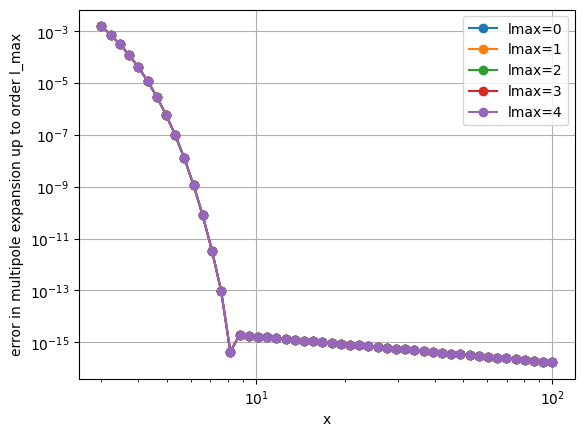

In [8]:
import matplotlib.pyplot as plt

rr = np.logspace(np.log10(3), np.log10(100), 50)

for l_max in range(5):
    phi = np.array([mpe(r, 0, 0, l_max=l_max) for r in rr])
    err = np.abs(phi - phi_ex(rr, sig))
    plt.loglog(rr, err, "-o", label=f"lmax={l_max}")
    
plt.legend()
plt.xlabel("x")
plt.grid()
plt.ylabel("error in multipole expansion up to order l_max")

All curves are on top of each other, so the monopole was sufficient for superb accuracy. That's not surprising,
since we have a radially symmetric charge distribution. 

Let's shift the charge distribution and see what happens. We now have

$$
\rho({\bf r}) = \frac{\exp\left(-|{\bf r}-{\bf R}|^2 / \sigma^2\right)}{\pi^{3/2}\sigma^3}
$$



and 

$$
\Phi({\bf r}) = \frac{{\rm erf}\left(|{\bf r}-{\bf R}|/\sigma\right)}{|{\bf r}-{\bf R}|}
$$

In [9]:
# shift along diagonal by 1 in x-direction:
R = np.sqrt((X-1)**2 + Y**2 + Z**2)

rho = np.exp(-R**2 / sig**2) / (np.pi**1.5 * sig**3)

mpe = MultipoleExpansion({'discrete': False, 'rho': rho, 'xyz': (X, Y, Z)}, l_max=8)

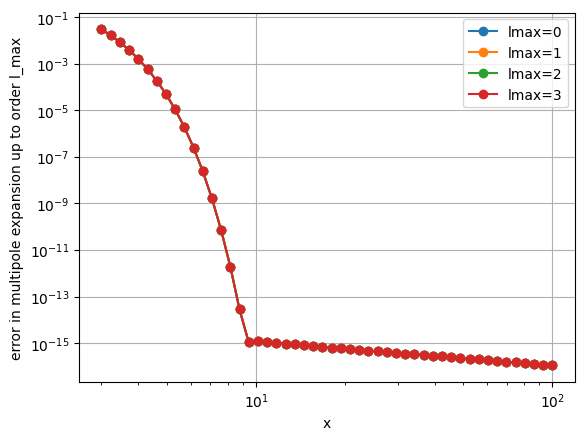

In [10]:
for l_max in range(4):
    
    phi = np.array([mpe(r, 0, 0, l_max=l_max) for r in rr])
    err = np.abs(phi - phi_ex(rr-1, sig))
    plt.loglog(rr, err, "-o", label=f"lmax={l_max}")
    
plt.legend()
plt.xlabel("x")
plt.ylabel("error in multipole expansion up to order l_max")
plt.grid()

All right. That's as expected. Now let's add a few Gaussian charge distributions so that we obtain more
non-zero multipole moments:

$$
\rho({\bf r}) = \sum_i \frac{Q_i\exp\left(-|{\bf r}-{\bf R_i}|^2 / \sigma^2\right)}{\pi^{3/2}\sigma^3}
$$

with corresponding exact potential

$$
\Phi({\bf r}) =\sum_i Q_i \frac{{\rm erf}\left(|{\bf r}-{\bf R_i}|/\sigma\right)}{|{\bf r}-{\bf R_i}|}
$$

In [11]:
Q = [1, -0.5, -1.5, 0.75]
pos = np.array(
    [(0, 0, 0), (1, 0, 0), (0, 1, 0), (-1, -1, -0.5)]
)

rho = np.zeros_like(X)
num_charges, _ = pos.shape
XYZ = X, Y, Z

phi_ex = np.zeros_like(rho)

for i in range(num_charges):
    xyz_i = pos[i, :]
    R = np.sqrt(sum((XYZ[k] - xyz_i[k])**2 for k in range(3)))
    rho += Q[i] * np.exp(-R**2 / sig**2) / (np.pi**1.5 * sig**3)

mpe = MultipoleExpansion({'discrete': False, 'rho': rho, 'xyz': (X, Y, Z)}, l_max=8)

In [12]:
def phi_ex_xyz(x, y, z, xyz0, Q):
    """The exact value of the potential for comparison."""
    num_charges, _ = xyz0.shape
    phi = 0
    for i in range(num_charges):
        r = np.sqrt((x-xyz0[i, 0])**2 + (y-xyz0[i, 1])**2 + (z-xyz0[i, 2])**2)
        phi += Q[i] * erf(r/sig) / r
    return phi

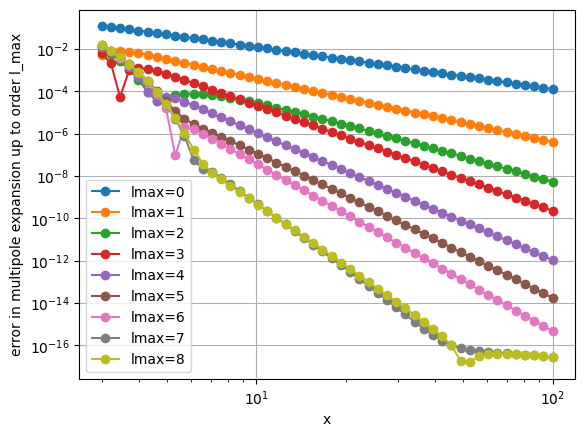

In [17]:
for l_max in range(9):
    phi = mpe(rr, 0, 0, l_max=l_max)
    err = np.abs(phi - phi_ex_xyz(rr, 0, 0, pos, Q))
    plt.loglog(rr, err, "-o", label=f"lmax={l_max}")
    
plt.legend()
plt.xlabel("x")
plt.ylabel("error in multipole expansion up to order l_max")
plt.grid()

Now we finally see get contributions from higher multipole moments. As expected, the more
moments we take into accounts, the smaller the error. Apparently, for our charge distribution,
calculating up to the octupole ($l_{max}=3$) should be sufficient for the most applications.